## TFIM (残留EE, 分割時間, 横磁場, 周期境界条件なし)

\[
H = - J \sum_i S_i^z S_{i+1}^z \;-\; h_x \sum_i S_i^x
\]

In [2]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

In [3]:
def simulate(N, J, hx, T_cut):
    cut_pos = N // 2 - 1
    sx, sz = qt.sigmax(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):  # 近接相互作用
        return (Sz[i] * Sz[i+1])

    H_cut_unit   = H_exchange(cut_pos)
    H_ex_rest    = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    H_trans_unit = sum(Sx[i] for i in range(N))

    # t=0 のフル結合ハミルトニアン（初期状態をとる用）
    H_full   = -J * (H_ex_rest + H_cut_unit) - hx * H_trans_unit
    # 時間依存部を除いた静的パート（= J'に依らない部分）
    H_static = -J * (H_ex_rest) - hx * H_trans_unit

    # 初期状態：t=0 の基底
    _, psi0 = H_full.groundstate(sparse=True)

    # ramp: 切断ボンドの係数を 1→0 に
    def ramp(t, T_cut):
        if T_cut <= 0.0:     # 無発展（瞬間クエンチ直後は psi0 のまま）
            return 0.0 if t > 0.0 else 1.0
        if t <= 0.0:  return 1.0
        if t >= T_cut: return 0.0
        return 1.0 - t / T_cut

    # 時間依存ハミルトニアン：H(t) = H_static + (-J * ramp) * H_cut_unit
    H_t = [H_static, [-J * H_cut_unit, lambda t, args: ramp(t, T_cut)]]

    tlist = [0.0, float(T_cut)]

    # 固い系向けの設定で積分を安定化
    opts = qt.Options(
        method='bdf',            # ← ここが効きます（デフォは 'adams'）
        rtol=1e-6,
        atol=1e-8,
        nsteps=200000,           # 十分大きく
        max_step=max(1e-6, float(T_cut)/50.0),  # ステップ制限（粗すぎを防ぐ）
        store_states=True,
        progress_bar=None,
    )

    result = qt.sesolve(H_t, psi0, tlist, options=opts)

    # 終時刻 T_cut の状態
    return result.states[-1]


0 (0.4766145618780478+0.8732057498037037j)
1 (-3.7339764613619764e-10-1.817127281977804e-09j)
2 (-1.359287471966357e-12-3.6396196950353646e-12j)
3 (-0.05513706172512003-0.024506569222378097j)
4 (-2.5743296383495817e-15+1.5508427875232655e-15j)


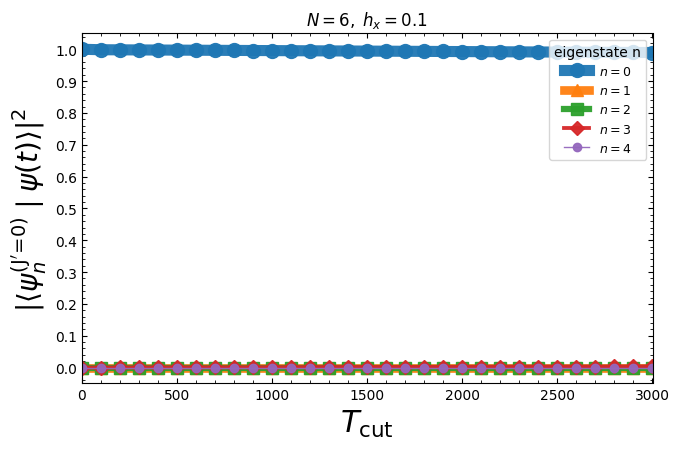

In [7]:
# 正規化
def to_np_unit(psi):
    v = psi.full().ravel() if hasattr(psi, "full") else np.asarray(psi).ravel()
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

hx_list   = [0.1]
N_list    = [6]
eig_idxes = [0, 1, 2, 3, 4]
T_cut_list = np.linspace(0.0, 3000.0, 31)
J = 1.0

max_lw, min_lw = 8.0, 1.0       # 線の太さ
max_ms, min_ms = 10.0, 6.0      # マーカーサイズ
linestyles_by_h = ['-', '--', '-.', ':']   # （今回は1枚に1つのhxなので未使用でもOK）
markers_by_n    = ['o','^','s','D']
n = len(eig_idxes)
lw_seq    = np.linspace(max_lw,  min_lw,  n)
ms_seq    = np.linspace(max_ms,  min_ms,  n)

for N in N_list:
    for h_idx, hx in enumerate(hx_list):
        # ←← ここで毎回新しい図を作る
        fig, ax = plt.subplots(figsize=(6.9, 4.6))

        # データ読み込み
        dat = np.load(f"../data/tfim/tfim_spectrum_and_states_N{N}_hx{hx}_J1.0_Jp_1to0.npz")
        J_p, eigvecs = dat["J_p"], dat["eigvecs"]
        # J_p = 0.0に一番近いものを取ってくる
        j0 = np.where(np.isclose(J_p, 1.0, atol=1e-12))[0][0]
        # j0 添字
        # n 固有状態のラベル
        # : ベクトル全体
        refs = np.stack([to_np_unit(eigvecs[j0, n, :]) for n in eig_idxes], axis=0)

        # --- フィデリティ計算（nごと）---
        for n_idx, n in enumerate(eig_idxes):
            fid = []
            for T_cut in T_cut_list:
                psi_t = simulate(N=N, J=J, hx=hx, T_cut=T_cut)
                psi_t = to_np_unit(psi_t)
                fid.append(float(np.abs(np.vdot(refs[n_idx], psi_t))**2))
                if (T_cut == 3000):
                    print(n_idx, np.vdot(refs[n_idx], psi_t))
                    

            ax.plot(
                T_cut_list, fid,
                marker=markers_by_n[n_idx % len(markers_by_n)],
                linewidth=lw_seq[n_idx],
                markersize=ms_seq[n_idx],
                alpha=0.95,
                label=fr"$n={n}$",
            )

        # 体裁（1枚に1つの hx / N）
        ax.set_xlim(T_cut_list.min(), T_cut_list.max())
        # ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel(r"$T_{\rm cut}$", fontsize=22)
        ax.set_ylabel(r"$|\langle \psi^{\mathrm{(J'\!=\!0)}}_{n} \mid \psi(t)\rangle|^2$", fontsize=20)
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        ax.xaxis.set_major_locator(MultipleLocator(500))
        ax.xaxis.set_minor_locator(MultipleLocator(100))
        ax.minorticks_on()
        ax.tick_params(which='both', direction='in', top=True, right=True)

        ax.set_title(fr"$N={N},\; h_x={hx:g}$")
        ax.legend(title="eigenstate n", fontsize=9, ncol=1, loc="upper right", frameon=True)

        fig.tight_layout()
        plt.show()

        OUTDIR = Path("../charts/TFIM"); 
        # fig.savefig(OUTDIR / f"fid_vs_Tcut_Jp0_N{N}_hx{hx}.pdf", bbox_inches="tight", dpi=300) 